# Dynamic Nelson-Siegel

## Introduction

The Dynamic Nelson-Siegel model introduced by [Diebold & LI (2006)](https://www.sciencedirect.com/science/article/abs/pii/S0304407605000795?via%3Dihub) uses a parametric curve to describe yield dynamics with the use of three latent dynamic factrors. 

The yield curve is determined by the [Nelson & Siegel(1987)](https://econpapers.repec.org/article/ucpjnlbus/v_3a60_3ay_3a1987_3ai_3a4_3ap_3a473-89.htm) equation

$$y_{t}(\tau) = \beta_{1t} + \beta_{2t} \left(\frac{1-e^{-\lambda_{t}t}}{\lambda_{t}t} \right)+ \beta_{3t} \left(\frac{1-e^{-\lambda_{t}t}}{\lambda_{t}t}-e^{-\lambda_{t}t} \right)$$

The loading factor $\lambda$ represents the exponential decay rate of the yield curve and it also determines the maturity at which $\beta_{3t}$ achieves its maximum.

The first loading factor $\beta_{1t}$ does not decay and therefore is a long-term factor and represents the level of the yield curve. 

The second factor $\beta_{2t}$, on the other hand, has the fastest decay and represents the curve's slope and may be understood as a short-term factor. 

Finally, the third factor $\beta_{3t}$ starts at zero and decays to zero and then is a medium term factor.

Small values of $\lambda$ will create rapid decay and therefore fit the curvature better at shorter maturities. Alike, large values of $\lambda$ will create slow decay and therefore fit the curvature better at longer maturities.

Following the original specification, let us begin by fixing $\lambda=0.069$ which corresponds to a maximum achieved at 30 months to the medium-term factor.

First, Let's import the data set and visualise the time series dynamics of the yields.

In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy as sc
import seaborn as sn
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import VAR
from tabulate import tabulate
#import pyflux as pf
#from Dynamic_Nelson_Siegel_Svensson_Kalman_Filter import kalman

In [2]:
#Importing data set
df = pd.read_csv("treasury.csv", header=None, names=['date','1m','3m','6m','12m','24m','36m','60m','84m','120m','240m'])

#Train test split
train, test = df[0:len(df)-4], df[len(df)-4:]

maturities = np.array([1.0,3.0,6.0,12.0,24.0,36.0,60.0,84.0,120.0,240.0])
maturities = pd.DataFrame(maturities)
yields = train.loc[:, train.columns != 'date']
yields_test = test.loc[:, test.columns != 'date']

## 2. Description of the data

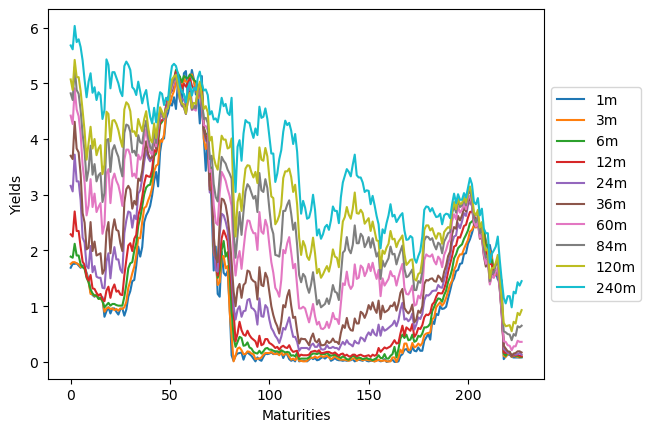

In [3]:
#Draw a diagram of the yields
yields.plot()
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Maturities")
plt.ylabel("Yields")
plt.show()

The data used is the Daily Treasury Yield Curve data obtained from the US Treasury. Monthly yields from January 2002 until April 2021 were used by taking the yield of the last day of every month. We have used rates for 1 month, 3 months, 6 months, 12 months, 24 months, 36 months, 60 months, 84 months, 120 months and 240 months maturity. For the 2 months and 360 months maturity the data set was incomplete and, thus, not utilised.

In [4]:
#Summary statistics of yields
yields.describe()

,1m,3m,6m,12m,24m,36m,60m,84m,120m,240m
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,1.220044,1.275395,1.382895,1.484342,1.701447,1.921228,2.368289,2.727807,3.050658,3.604298
std,1.469681,1.493946,1.523630,1.491573,1.417497,1.357861,1.264883,1.197847,1.161271,1.204731
min,0.000000,0.000000,0.030000,0.090000,0.110000,0.110000,0.210000,0.390000,0.550000,0.980000
25%,0.070000,0.090000,0.150000,0.235000,0.545000,0.880000,1.425000,1.877500,2.167500,2.630000
50%,0.820000,0.910000,1.000000,1.110000,1.300000,1.515000,2.060000,2.610000,2.870000,3.500000
75%,1.762500,1.892500,2.047500,2.242500,2.520000,2.755000,3.285000,3.700000,4.025000,4.740000
max,5.240000,5.160000,5.240000,5.210000,5.160000,5.130000,5.100000,5.290000,5.420000,6.030000


Next, let us visualize the loading factors dynamics

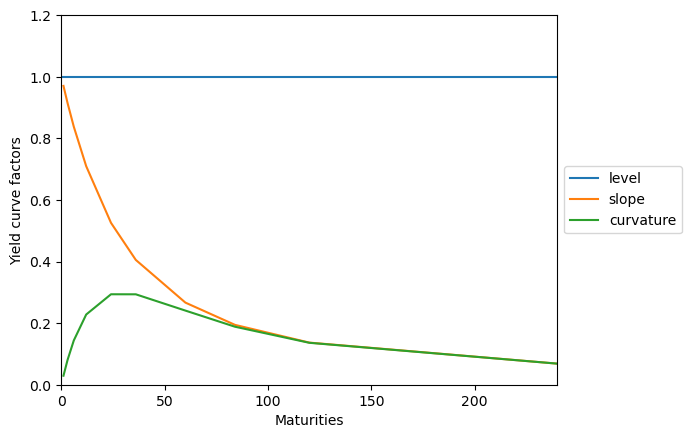

In [5]:
#Creating the factors matrix with the standard loading factor lambda = 0.0609
lambda0 = 0.0609

maturities = np.array([1.0,3.0,6.0,12.0,24.0,36.0,60.0,84.0,120.0,240.0])

level = maturities*(1/maturities)
slope = (1-np.exp(-lambda0*maturities))/(lambda0*maturities)
curvature = (1-np.exp(-lambda0*maturities))/(lambda0*maturities)-np.exp(-lambda0*maturities)

#Draw a diagram of the three loading factors
plt.plot(maturities,level,label='level')
plt.plot(maturities,slope,label='slope')
plt.plot(maturities,curvature,label='curvature')
plt.ylabel('Yield curve factors')
plt.xlabel('Maturities')
plt.axis([0, 240, 0, 1.2])
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Implementation

### Two-Steps estimation: OLS for yields dynamic and AR(1) for latent factors dynamic

In [32]:
#Creating loading factors matrix for estimation
matx = np.column_stack([level,slope,curvature])
col = ['level','slope','curvature']
X = pd.DataFrame(matx,columns = col)

#Creating the parameter and residual matrixes
n,p = yields.shape
beta = np.zeros((n,3))
resid = np.zeros((n,p))

#Estimating the level, slope and curvature parameters for each maturity and date with OLS
for i in range (0,n):
    linreg = LinearRegression(fit_intercept=False,normalize=False)
    linreg.fit(X,np.transpose(yields[i:i+1]))
    beta[i,:] = linreg.coef_
    resid[i:i+1] = yields[i:i+1] - np.transpose(linreg.predict(X))
    
#Transforming the parameter matrix into arrays to prepare for AR(1) fit
b1 = beta[:,0]
b2 = beta[:,1]
b3 = beta[:,2]

#Train AR(1) for the parameters
model_b1 = AutoReg(b1, lags=1).fit()
model_b2 = AutoReg(b2, lags=1).fit()
model_b3 = AutoReg(b3, lags=1).fit()

b1_hat = model_b1.params
b2_hat = model_b2.params
b3_hat = model_b3.params

### Kalman Filter

In [33]:
# Using a VAR(1) to fit the parameters time series
model = VAR(beta)
result = model.fit(1)

co_var = np.row_stack(result.coefs[0])
coeff_var = pd.DataFrame(co_var)
print(coeff_var)

cov_var = np.row_stack(result.resid_corr)
covv_var = pd.DataFrame(cov_var)
print(covv_var)

          0         1         2
0  0.983271  0.016906 -0.008843
1 -0.002022  0.898905  0.073852
2  0.001634  0.079934  0.907553
          0         1         2
0  1.000000 -0.789394 -0.075870
1 -0.789394  1.000000 -0.112131
2 -0.075870 -0.112131  1.000000


In [34]:
#Obtaining values for the matrix Q: yields residual matrix
resids = pd.DataFrame(result.resid, columns=('r1','r2','r3'))
r1 = resids['r1']
r2 = resids['r2']
r3 = resids['r3']
Q1 = np.var(r1)
Q2 = np.var(r2)
Q3 = np.var(r3)
print(Q1)
print(Q2)
print(Q3)

0.07363119883059394
0.10699392901668602
0.4063080751345085


In [35]:
#Obtaining values for the matrix H: parameters residual matrix
resids2 = pd.DataFrame(resid, columns=('H1','H2','H3','H4','H5','H6','H7','H8','H9','H10'))
H1 = np.sqrt(np.var(resids2['H1']))
H2 = np.sqrt(np.var(resids2['H2']))
H3 = np.sqrt(np.var(resids2['H3']))
H4 = np.sqrt(np.var(resids2['H4']))
H5 = np.sqrt(np.var(resids2['H5']))
H6 = np.sqrt(np.var(resids2['H6']))
H7 = np.sqrt(np.var(resids2['H7']))
H8 = np.sqrt(np.var(resids2['H8']))
H9 = np.sqrt(np.var(resids2['H9']))
H10 = np.sqrt(np.var(resids2['H10']))
print(H1)
print(H2)
print(H3)
print(H4)
print(H5)
print(H6)
print(H7)
print(H8)
print(H9)
print(H10)

0.08308624839734234
0.043218217226109024
0.06732809242877423
0.0808953673169966
0.04949496020610069
0.04409587359583859
0.07473324071485579
0.0713750032999941
0.045934022783612985
0.08380234721031957


In [36]:
#Obtaining the mean of the latent factors
betas = pd.DataFrame(beta, columns=('b1','b2','b3'))
mu_1 = np.mean(betas['b1'])
mu_2 = np.mean(betas['b2'])
mu_3 = np.mean(betas['b3'])
print(mu_1)
print(mu_2)
print(mu_3)

3.841385568394337
-2.520480304485055
-2.9392473219197544


In [37]:
#Running the Kalman Filter
mty =  np.array([1,3,6,12,24,36,60,84,120,240])

param = np.array([-2.798522, # log of 0.0609
0.08308624839734234, 0.043218217226109024, 0.06732809242877423, 0.0808953673169966, 0.04949496020610069, 0.04409587359583859,
0.07473324071485579, 0.0713750032999941, 0.045934022783612985, 0.08380234721031957, # H
0.983271, 0.016906, -0.008843, # phi
-0.002022, 0.898905, 0.073852, # phi
0.001634, 0.079934, 0.907553, # phi
3.841385568394337, -2.520480304485055, -2.9392473219197544,  # mu
0.07363119883059394, 0, 0, 0.10699392901668602, 0, 0.4063080751345085])# Q

kalman(param = param,Y = yields, lik = True, frct = False, ahead = 0, mty = mty, model = 'NS')

510.7887604277325

### Two-Steps estimation: OLS for yields dynamic and VAR(1) with Metropolis-Hastings for latent factors dynamic

In [38]:
#Estimating the VAR(1) of the parameters with the Metropolis-Hastings algorithm
model_mh = pf.VAR(data=betas, lags=1)
m_mh = model_mh.fit('M-H', nsims=5000)

Acceptance rate of Metropolis-Hastings is 0.0039
Acceptance rate of Metropolis-Hastings is 0.1029
Acceptance rate of Metropolis-Hastings is 0.174
Acceptance rate of Metropolis-Hastings is 0.2744

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.22355
Acceptance rate of Metropolis-Hastings is 0.4014
Acceptance rate of Metropolis-Hastings is 0.2678


## Forecasting Yields

### Two-Steps estimation: OLS for yields dynamic and AR(1) for latent factors dynamic

In [39]:
#Making predictions with AR(1) model
pred1 = model_b1.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
pred2 = model_b2.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
pred3 = model_b3.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

matx = np.row_stack([pred1,pred2,pred3])

#Forecasting yields for the AR(1) model as a Pandas Data Frame
yields_forecasted_ar1 = np.dot(X,matx)
yar1 = np.transpose(yields_forecasted_ar1)
ar1 = pd.DataFrame(yar1, columns=('1m','3m','6m','12m','24m','36m','60m','84m','120m','240m'))
print(ar1)

         1m        3m        6m       12m       24m       36m       60m  \
0  0.196667  0.127902  0.055164 -0.007884  0.054655  0.215466  0.547095   
1  0.212659  0.144286  0.072161  0.010380  0.075344  0.238220  0.572812   
2  0.228340  0.160360  0.088848  0.028319  0.095662  0.260549  0.598011   
3  0.243715  0.176130  0.105228  0.045938  0.115611  0.282456  0.622702   

        84m      120m      240m  
0  0.789045  1.010913  1.289995  
1  0.816581  1.040015  1.321018  
2  0.843540  1.068485  1.351342  
3  0.869932  1.096337  1.380984  


### Kalman Filter

In [40]:
#Forecasting parameters 4 periods ahead with the Kalman Filter
kalman(param = param,Y = yields, lik = False, frct = True, ahead = 4, mty = mty, model = 'NS')

(array([[ 5.97904238e+00, -4.43230479e+00, -1.82578513e+00],
        [ 5.84011941e+00, -4.26373175e+00, -1.87468696e+00],
        [ 6.05447266e+00, -4.55641797e+00,  5.74391604e-02],
        [ 5.93879016e+00, -4.43547729e+00, -1.20066730e+00],
        [ 5.94004751e+00, -4.41860573e+00, -1.43706059e+00],
        [ 5.85371663e+00, -4.32316458e+00, -2.50822994e+00],
        [ 5.77387541e+00, -4.06194941e+00, -4.75754617e+00],
        [ 5.49547502e+00, -3.74372489e+00, -4.99923865e+00],
        [ 5.09814534e+00, -3.37355704e+00, -5.77759987e+00],
        [ 5.25454851e+00, -3.63388638e+00, -5.78042454e+00],
        [ 5.40188279e+00, -4.12108557e+00, -4.18985628e+00],
        [ 5.20793956e+00, -3.90114707e+00, -5.40657857e+00],
        [ 5.28515097e+00, -4.03474734e+00, -5.02300691e+00],
        [ 5.10903178e+00, -3.80102930e+00, -5.55737103e+00],
        [ 5.18041752e+00, -3.91758890e+00, -5.57424515e+00],
        [ 5.22900968e+00, -3.98484295e+00, -5.55525250e+00],
        [ 4.84743503e+00

In [41]:
#Add Kalman Filter forecasted yields as Pandas Data Frame
yields_forecasted_kalman = np.array([[0.1286313 , 0.0853668 , 0.04299476, 0.01874446, 0.10534755,
         0.25714442, 0.54815169, 0.75466524, 0.94228462, 1.17746613],
        [0.11856664, 0.08064293, 0.04530851, 0.03226448, 0.13334973,
         0.29337287, 0.59232782, 0.8022663 , 0.99230887, 1.23020273],
        [0.11460104, 0.08109925, 0.05161444, 0.04795231, 0.16134579,
         0.32852023, 0.6346092 , 0.84774834, 1.04012012, 1.28066033],
        [0.11558919, 0.08574964, 0.06113183, 0.06534131, 0.18923956,
         0.36266992, 0.67520941, 0.89135668, 1.08597363, 1.32909781]])
yfk = np.row_stack(yields_forecasted_kalman)
kf = pd.DataFrame(yfk, columns=('1m','3m','6m','12m','24m','36m','60m','84m','120m','240m'))
print(kf)

         1m        3m        6m       12m       24m       36m       60m  \
0  0.128631  0.085367  0.042995  0.018744  0.105348  0.257144  0.548152   
1  0.118567  0.080643  0.045309  0.032264  0.133350  0.293373  0.592328   
2  0.114601  0.081099  0.051614  0.047952  0.161346  0.328520  0.634609   
3  0.115589  0.085750  0.061132  0.065341  0.189240  0.362670  0.675209   

        84m      120m      240m  
0  0.754665  0.942285  1.177466  
1  0.802266  0.992309  1.230203  
2  0.847748  1.040120  1.280660  
3  0.891357  1.085974  1.329098  


### Two-Steps estimation: OLS for yields dynamic and VAR(1) with Metropolis-Hastings for latent factors dynamic

In [42]:
#Predicting parameters
mat_mh = np.transpose(model_mh.predict(4))

In [43]:
#Forecasting yields with the Metropolis-Hastings algorithm
yields_forecasted_mh = np.dot(X,mat_mh)
ymh = np.transpose(yields_forecasted_mh)
mh = pd.DataFrame(ymh, columns=('1m','3m','6m','12m','24m','36m','60m','84m','120m','240m'))
print(mh)

         1m        3m        6m       12m       24m       36m       60m  \
0  0.142630  0.078963  0.012875 -0.039785  0.035632  0.203283  0.540851   
1  0.111610  0.052353 -0.007861 -0.050978  0.037288  0.212687  0.558373   
2  0.085956  0.030249 -0.025199 -0.060470  0.038636  0.220803  0.573885   
3  0.064598  0.011758 -0.039808 -0.068591  0.039741  0.227878  0.587757   

        84m      120m      240m  
0  0.784984  1.008204  1.288683  
1  0.806361  1.032490  1.316335  
2  0.825542  1.054514  1.341690  
3  0.842920  1.074667  1.365131  


### Calculating RMSE and ploting forecasts

In [44]:
#Transforming test data in a Pandas Data Frame
yt = pd.DataFrame(yields_test, columns=('1m','3m','6m','12m','24m','36m','60m','84m','120m','240m'))

#Creating Root Mean Squared Error Table

# Two-Steps Metropolis-Hastings VAR(1) 
rmse_1m_mh = round(np.sqrt(mean_squared_error(yt['1m'], mh['1m'])),3)
rmse_3m_mh = round(np.sqrt(mean_squared_error(yt['3m'], mh['3m'])),3)
rmse_6m_mh = round(np.sqrt(mean_squared_error(yt['6m'], mh['6m'])),3)
rmse_12m_mh = round(np.sqrt(mean_squared_error(yt['12m'], mh['12m'])),3)
rmse_24m_mh = round(np.sqrt(mean_squared_error(yt['24m'], mh['24m'])),3)
rmse_36m_mh = round(np.sqrt(mean_squared_error(yt['36m'], mh['36m'])),3)
rmse_60m_mh = round(np.sqrt(mean_squared_error(yt['60m'], mh['60m'])),3)
rmse_84m_mh = round(np.sqrt(mean_squared_error(yt['84m'], mh['84m'])),3)
rmse_120m_mh = round(np.sqrt(mean_squared_error(yt['120m'], mh['120m'])),3)
rmse_240m_mh = round(np.sqrt(mean_squared_error(yt['240m'], mh['240m'])),3)

#Kalman Filter
rmse_1m_kf = round(np.sqrt(mean_squared_error(yt['1m'], kf['1m'])),3)
rmse_3m_kf = round(np.sqrt(mean_squared_error(yt['3m'], kf['3m'])),3)
rmse_6m_kf = round(np.sqrt(mean_squared_error(yt['6m'], kf['6m'])),3)
rmse_12m_kf = round(np.sqrt(mean_squared_error(yt['12m'], kf['12m'])),3)
rmse_24m_kf = round(np.sqrt(mean_squared_error(yt['24m'], kf['24m'])),3)
rmse_36m_kf = round(np.sqrt(mean_squared_error(yt['36m'], kf['36m'])),3)
rmse_60m_kf = round(np.sqrt(mean_squared_error(yt['60m'], kf['60m'])),3)
rmse_84m_kf = round(np.sqrt(mean_squared_error(yt['84m'], kf['84m'])),3)
rmse_120m_kf = round(np.sqrt(mean_squared_error(yt['120m'], kf['120m'])),3)
rmse_240m_kf = round(np.sqrt(mean_squared_error(yt['240m'], kf['240m'])),3)

#Two-Steps AR(1)  
rmse_1m_ar1 = round(np.sqrt(mean_squared_error(yt['1m'], ar1['1m'])),3)
rmse_3m_ar1 = round(np.sqrt(mean_squared_error(yt['3m'], ar1['3m'])),3)
rmse_6m_ar1 = round(np.sqrt(mean_squared_error(yt['6m'], ar1['6m'])),3)
rmse_12m_ar1 = round(np.sqrt(mean_squared_error(yt['12m'], ar1['12m'])),3)
rmse_24m_ar1 = round(np.sqrt(mean_squared_error(yt['24m'], ar1['24m'])),3)
rmse_36m_ar1 = round(np.sqrt(mean_squared_error(yt['36m'], ar1['36m'])),3)
rmse_60m_ar1 = round(np.sqrt(mean_squared_error(yt['60m'], ar1['60m'])),3)
rmse_84m_ar1 = round(np.sqrt(mean_squared_error(yt['84m'], ar1['84m'])),3)
rmse_120m_ar1 = round(np.sqrt(mean_squared_error(yt['120m'], ar1['120m'])),3)
rmse_240m_ar1 = round(np.sqrt(mean_squared_error(yt['240m'], ar1['240m'])),3)

table = [['Model','1m','3m','6m','12m','24m','36m','60m','84m','120m','240m'],
         ['Two-Steps AR(1)',rmse_1m_ar1,rmse_3m_ar1,rmse_6m_ar1,rmse_12m_ar1,rmse_24m_ar1,rmse_36m_ar1,rmse_60m_ar1,rmse_84m_ar1,rmse_120m_ar1,rmse_240m_ar1],
         ['Kalman Filter',rmse_1m_kf,rmse_3m_kf,rmse_6m_kf,rmse_12m_kf,rmse_24m_kf,rmse_36m_kf,rmse_60m_kf,rmse_84m_kf,rmse_120m_kf,rmse_240m_kf],
         ['Two-Steps BVAR(1)',rmse_1m_mh,rmse_3m_mh,rmse_6m_mh,rmse_12m_mh,rmse_24m_mh,rmse_36m_mh,rmse_60m_mh,rmse_84m_mh,rmse_120m_mh,rmse_240m_mh]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════╤════════╕
│ Model             │    1m │    3m │    6m │   12m │   24m │   36m │   60m │   84m │   120m │   240m │
╞═══════════════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪════════╪════════╡
│ Two-Steps AR(1)   │ 0.192 │ 0.123 │ 0.044 │ 0.068 │ 0.058 │ 0.065 │ 0.224 │ 0.395 │  0.481 │  0.759 │
├───────────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼────────┼────────┤
│ Kalman Filter     │ 0.089 │ 0.052 │ 0.021 │ 0.049 │ 0.015 │ 0.036 │ 0.194 │ 0.391 │  0.509 │  0.833 │
├───────────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼────────┼────────┤
│ Two-Steps BVAR(1) │ 0.069 │ 0.011 │ 0.065 │ 0.13  │ 0.106 │ 0.099 │ 0.244 │ 0.411 │  0.494 │  0.767 │
╘═══════════════════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╧════════╧════════╛


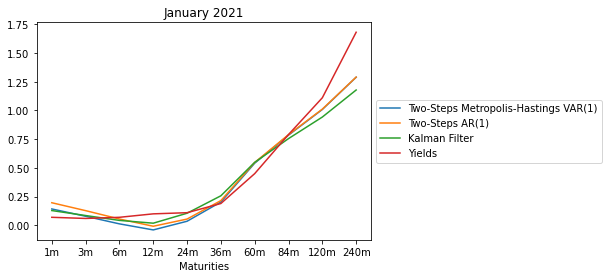

In [45]:
#Draw a diagram of the forecasted term structures vs real data January 2021
plt.plot(yields_forecasted_mh[:,0],label='Two-Steps Metropolis-Hastings VAR(1)')
plt.plot(yields_forecasted_ar1[:,0],label='Two-Steps AR(1) ')
plt.plot(yields_forecasted_kalman[0,:],label='Kalman Filter')
plt.plot(yt.iloc[0],label='Yields')
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Maturities")
plt.title("January 2021")
plt.show()

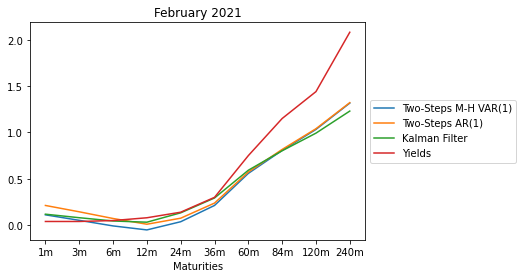

In [46]:
#Draw a diagram of the forecasted term structures vs real data February 2021
plt.plot(yields_forecasted_mh[:,1],label='Two-Steps M-H VAR(1)')
plt.plot(yields_forecasted_ar1[:,1],label='Two-Steps AR(1) ')
plt.plot(yields_forecasted_kalman[1,:],label='Kalman Filter')
plt.plot(yt.iloc[1],label='Yields')
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Maturities")
plt.title("February 2021")
plt.show()

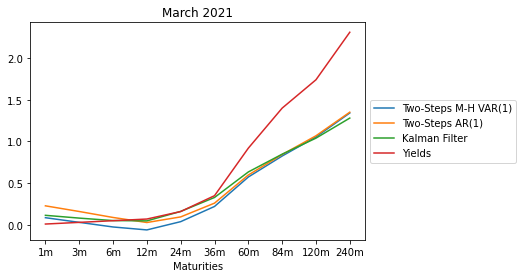

In [47]:
#Draw a diagram of the forecasted term structures vs real data March 2021
plt.plot(yields_forecasted_mh[:,2],label='Two-Steps M-H VAR(1)')
plt.plot(yields_forecasted_ar1[:,2],label='Two-Steps AR(1) ')
plt.plot(yields_forecasted_kalman[2,:],label='Kalman Filter')
plt.plot(yt.iloc[2],label='Yields')
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Maturities")
plt.title("March 2021")
plt.show()

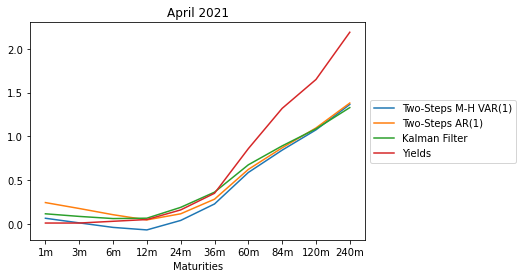

In [48]:
#Draw a diagram of the forecasted term structures vs real data April 2021
plt.plot(yields_forecasted_mh[:,3],label='Two-Steps M-H VAR(1)')
plt.plot(yields_forecasted_ar1[:,3],label='Two-Steps AR(1) ')
plt.plot(yields_forecasted_kalman[3,:],label='Kalman Filter')
plt.plot(yt.iloc[3],label='Yields')
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Maturities")
plt.title("April 2021")
plt.show()